# Import Required Libraries
Import the necessary libraries, including PyTorch.

In [1]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from fastcore.all import *

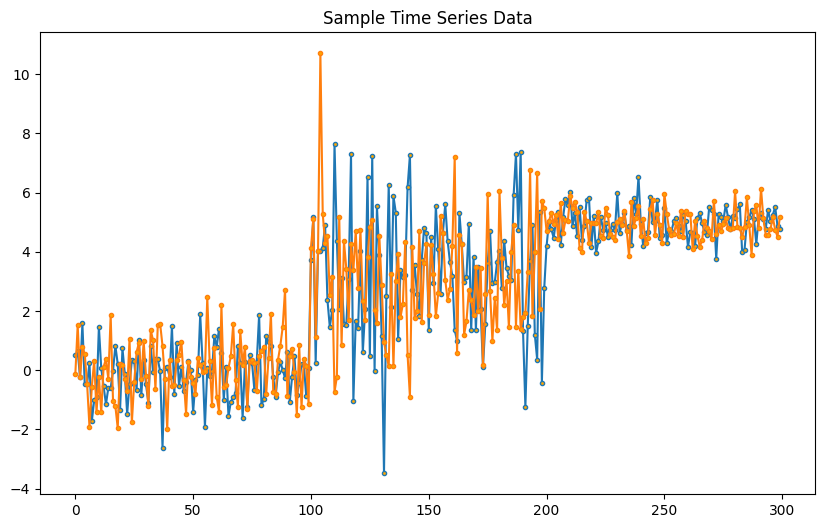

In [2]:
# Generate some sample data
np.random.seed(42)
X = np.concatenate([np.random.normal(size=(100, 2)),
                    np.random.normal(loc=3.0, scale=2.0, size=(100, 2)),
                    np.random.normal(loc=5.0, scale=0.5, size=(100, 2))])
# Plot X as a time series
plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], ".-", label="observations", ms=6, mfc="orange")
plt.plot(X[:, 1], ".-", label="observations", ms=6, mfc="orange")
plt.title("Sample Time Series Data")
plt.show()



________

<u><b>The Forward Algorithm (Log Domain)</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\text{log }\alpha_{s,1} := \text{log }b_s(x_1) + \text{log }\pi_s$ 
> 
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
> $\text{log }\alpha_{s,t} := \text{log }b_s(x_t) +  \underset{s'}{\text{logsumexp}} \left( \text{log }A_{s, s'} + \text{log }\alpha_{s',t-1} \right)$
> 
> $\text{log }p(\mathbf{x}) := \underset{s}{\text{logsumexp}} \left( \text{log }\alpha_{s,T} \right)$\
> return $\text{log }p(\mathbf{x})$
________

In this implementation we are returning the negative log likelihood instead of
the log likelihood

In [3]:
class GaussianHMM(nn.Module):
    def __init__(self, n_states, n_features):
        super(GaussianHMM, self).__init__()
        self.n_states = n_states
        self.n_features = n_features
        # Parameters: Initial probabilities, Transition matrix, Mean and Covariance for Gaussian emissions
        self.init_probs_logits = nn.Parameter(torch.randn(n_states))
        self.trans_mat_logits = nn.Parameter(torch.randn(n_states, n_states))
        self.means = nn.Parameter(torch.randn(n_states, n_features))
        self.covs_L = nn.Parameter(torch.randn(n_states, n_features * (n_features + 1) // 2))
    def forward(self, X):
        covs_L = torch.zeros(self.n_states, self.n_features, self.n_features)
        tril_indices = torch.tril_indices(self.n_features, self.n_features)
        covs_L[:, tril_indices[0], tril_indices[1]] = self.covs_L
 
        covs = torch.matmul(covs_L, covs_L.permute(0, 2, 1))
        covs_inv = torch.cholesky_inverse(covs_L)
 
        init_probs_logs = torch.nn.functional.log_softmax(self.init_probs_logits, dim=-1)
        trans_mat_logs = torch.nn.functional.log_softmax(self.trans_mat_logits, dim=-1)
 
        # Forward algorithm to compute log likelihood of X
        T = X.size(0)
        log_alpha = torch.zeros(T, self.n_states)
        # Initialization
        log_alpha[0] = init_probs_logs
        log_likelihood = init_probs_logs + self.gaussian_log_prob(X[0], covs, covs_inv)
        # Induction
        for t in range(1, T):
            log_alpha[t] = torch.logsumexp(log_alpha[t-1].unsqueeze(-1) + trans_mat_logs, dim=0)
            log_likelihood += torch.logsumexp(self.gaussian_log_prob(X[t], covs, covs_inv) + log_alpha[t], dim=-1)
        # Termination
        return -log_likelihood.mean()  # Return negative log-likelihood
    def gaussian_log_prob(self, x, covs, covs_inv):
        # Compute log probability of x under each Gaussian emission
        diffs = x - self.means
        exp_term = torch.einsum('bi, bij, bj -> b', diffs, covs_inv, diffs)
        norm_const = torch.logdet(covs) + self.n_features * torch.log(torch.tensor(2 * torch.pi))
        log_prob = -0.5 * (norm_const + exp_term)
        return log_prob

In [4]:
n_states = 3
model = GaussianHMM(n_states, X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
X = torch.tensor(X, dtype=torch.float32)
for i in range(3000):
    optimizer.zero_grad()
    loss = model(X)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Loss at iteration {i}: {loss.item()}") 

/home/victor/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loss at iteration 0: 4877.873046875
Loss at iteration 100: 1770.2681884765625
Loss at iteration 200: 1478.0552978515625
Loss at iteration 300: 1367.7576904296875
Loss at iteration 400: 1313.7772216796875
Loss at iteration 500: 1284.7735595703125
Loss at iteration 600: 1268.3026123046875
Loss at iteration 700: 1258.5831298828125
Loss at iteration 800: 1252.6734619140625
Loss at iteration 900: 1248.943359375
Loss at iteration 1000: 1246.4373779296875
Loss at iteration 1100: 1244.5677490234375
Loss at iteration 1200: 1242.9881591796875
Loss at iteration 1300: 1241.4732666015625
Loss at iteration 1400: 1239.93408203125
Loss at iteration 1500: 1238.3486328125
Loss at iteration 1600: 1236.6912841796875
Loss at iteration 1700: 1234.92529296875
Loss at iteration 1800: 1233.024169921875
Loss at iteration 1900: 1230.9163818359375
Loss at iteration 2000: 1228.4388427734375
Loss at iteration 2100: 1225.2906494140625
Loss at iteration 2200: 1220.9163818359375
Loss at iteration 2300: 1214.0916748046

In [14]:
# Convert log probabilities back to probabilities
start_probs = torch.exp(torch.nn.functional.log_softmax(model.init_probs_logits, dim=-1))
trans_probs = torch.exp(torch.nn.functional.log_softmax(model.trans_mat_logits, dim=-1))

# Emission parameters
emission_means = model.means

# Compute covariance matrices from covs_L to get standard deviations
covs_L = torch.zeros(model.n_states, model.n_features, model.n_features)
tril_indices = torch.tril_indices(model.n_features, model.n_features)
covs_L[:, tril_indices[0], tril_indices[1]] = model.covs_L
covs = torch.matmul(covs_L, covs_L.permute(0, 2, 1))
emission_stddev = torch.sqrt(torch.diagonal(covs, dim1=-2, dim2=-1))

# Print the parameters
print(f"Start Probabilities: {start_probs}")
print(f"Transition Probabilities:\n {trans_probs}")
print(f"Emission Mean: {emission_means}")
print(f"Emission Stddev:\n {emission_stddev}")

# Compute and print the log probability of the observations
neg_log_lik = model(X)
print(f"Negative Log Probability of Observations: {neg_log_lik}")

# To print the actual probability, convert the log probability using exp
prob_of_observations = torch.exp(-1*neg_log_lik)
print(f"Probability of Observations: {prob_of_observations:.15e}")

Start Probabilities: tensor([0.2243, 0.5270, 0.2488], grad_fn=<ExpBackward0>)
Transition Probabilities:
 tensor([[0.4926, 0.3695, 0.1379],
        [0.0972, 0.1068, 0.7960],
        [0.4590, 0.1010, 0.4400]], grad_fn=<ExpBackward0>)
Emission Mean: Parameter containing:
tensor([[4.8764, 4.8590],
        [3.0390, 1.4934],
        [0.3581, 1.1396]], requires_grad=True)
Emission Stddev:
 tensor([[0.6685, 0.5984],
        [2.5838, 1.3593],
        [1.1986, 2.2451]], grad_fn=<SqrtBackward0>)
Negative Log Probability of Observations: 1146.8125
Probability of Observations: 0.000000000000000e+00


In [5]:
# Print the model parameters
print(f"Start Probabilities (logits): {model.init_probs_logits}")
print(f"Transition Probabilities (logits): {model.trans_mat_logits}")
print(f"Emission Mean: {model.means}")
print(f"Emission Stddev: {model.covs_L}")

# Print the log probability of the observations
print(f"Log Probability of Observations: {model(X)}")

Start Probabilities: Parameter containing:
tensor([0.0273, 0.8816, 0.1309], requires_grad=True)
Transition Probabilities: Parameter containing:
tensor([[ 1.5520,  1.2646,  0.2788],
        [-0.7523, -0.6589,  1.3502],
        [ 1.1005, -0.4133,  1.0581]], requires_grad=True)
Emission Mean: Parameter containing:
tensor([[4.8764, 4.8590],
        [3.0390, 1.4934],
        [0.3581, 1.1396]], requires_grad=True)
Emission Stddev: Parameter containing:
tensor([[ 0.6685,  0.1779, -0.5714],
        [ 2.5838,  0.3886, -1.3026],
        [-1.1986, -1.4264,  1.7338]], requires_grad=True)
Log Probability of Observations: 1146.8125


## Viterbi algorithm
> Decode most likely hidden state sequence

In [6]:
@patch
def viterbi(self: GaussianHMM, X):
    T = X.size(0)
    log_delta = torch.zeros(T, self.n_states)
    psi = torch.zeros(T, self.n_states, dtype=torch.long)
    
    # Compute covariances and their inverses
    covs_L = torch.zeros(self.n_states, self.n_features, self.n_features)
    tril_indices = torch.tril_indices(self.n_features, self.n_features)
    covs_L[:, tril_indices[0], tril_indices[1]] = self.covs_L
    covs = torch.matmul(covs_L, covs_L.permute(0, 2, 1))
    covs_inv = torch.cholesky_inverse(covs_L)

    # Convert logits to log probabilities
    init_probs_logs = torch.nn.functional.log_softmax(self.init_probs_logits, dim=-1)
    trans_mat_logs = torch.nn.functional.log_softmax(self.trans_mat_logits, dim=-1)
    
    # Initialization
    log_delta[0] = init_probs_logs + self.gaussian_log_prob(X[0], covs, covs_inv)
    
    # Recursion
    for t in range(1, T):
        max_vals, max_inds = torch.max(log_delta[t-1].unsqueeze(-1) + trans_mat_logs, dim=0)
        log_delta[t] = self.gaussian_log_prob(X[t], covs, covs_inv) + max_vals
        psi[t] = max_inds
    
    # Termination
    _, last_state = torch.max(log_delta[-1], dim=0)
    path = [last_state.item()]
    
    # Path backtracking
    for t in range(T-1, 0, -1):
        last_state = psi[t, last_state]
        path.insert(0, last_state.item())
    
    return path


In [7]:
# Find the most likely state sequence
path = model.viterbi(X)
print(f"Most Likely State Sequence: {path}")


Most Likely State Sequence: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


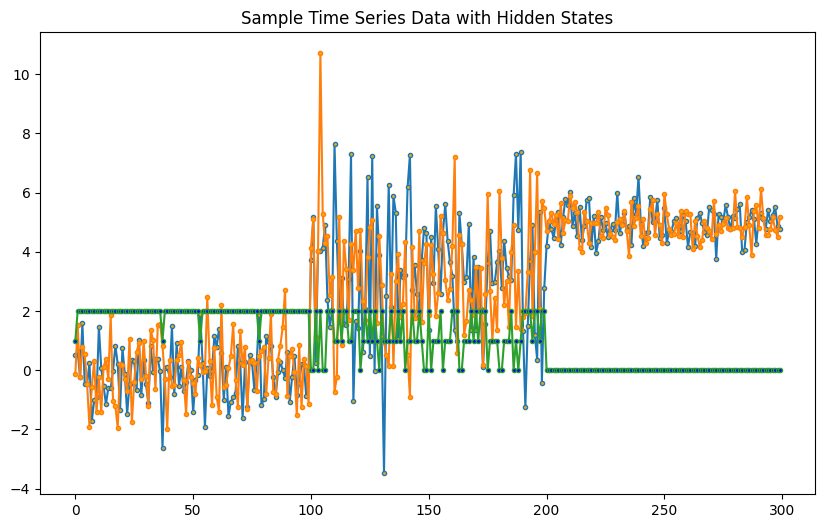

In [8]:
# Plot hidden state on top of the sample data
plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], ".-", label="observations", ms=6, mfc="orange")
plt.plot(X[:, 1], ".-", label="observations", ms=6, mfc="orange")
plt.plot(path, ".-", label="hidden states", ms=6, mfc="blue")
plt.title("Sample Time Series Data with Hidden States")
plt.show()


## Model selection with Bayesian Information Criterion (BIC)

TODO by students

The Bayesian Information Criterion (BIC) is a criterion for model selection among a finite set of models; it is based on the likelihood function and takes into consideration the number of parameters in the model. It is particularly useful in scenarios like selecting the best Hidden Markov Model (HMM) from a set of HMMs that differ in the number of states or in the structure of the transition matrix.

The formula for BIC is given by:

\[ \text{BIC} = -2 \cdot \ln(\hat{L}) + k \cdot \ln(n) \]

where:
- \(\hat{L}\) is the maximized value of the likelihood function of the model. For HMMs, this is typically obtained using algorithms like the Baum-Welch algorithm, which finds the set of model parameters that maximizes the likelihood of the observed sequence of emissions.
- \(k\) is the number of free parameters to be estimated. In the context of HMMs, this includes the parameters of the emission probability distributions, the initial state distribution, and the state transition probabilities.
- \(n\) is the number of data points, which, for HMMs, would be the length of the observed sequence of emissions. If the model is fitted on multiple sequences, n would be the sum of the lengths of all sequences.

The BIC penalizes complex models, which is reflected by the term involving the number of parameters \(k\). The idea is to balance model complexity with goodness of fit. Lower values of BIC indicate a better model, taking into consideration both the likelihood and the number of parameters. When selecting among multiple HMMs, the one with the lowest BIC is generally preferred as it suggests the model is more likely to be the true generator of the observed data, without being unnecessarily complex.





